In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import sys
import seaborn as sns
import numpy as np
from scipy import ndimage


sys.path.append('../shared')
from file_analyzer import FileAnalyzer


# Analyze your file
analyzer = FileAnalyzer('../../data/independent_expenditure_2024.csv')
analyzer.print_summary()

df = analyzer.get_dataframe()

# 2 Steps to cleaning data - first remove duplicates and then remove problematic spenders
# Remove duplicates keeping the latest file (amended reports)
df_clean = df.sort_values(['spe_id', 'exp_date', 'cand_id', 'file_num'])
df_clean = df_clean.drop_duplicates(subset=['spe_id', 'exp_date', 'cand_id', 'exp_amo'], keep='last')
df = df_clean

# Remove problematic spenders
spenders_to_remove = [
    'THE COMMITTEE OF 300',
    'THE COURT OF DIVINE JUSTICE', 
    'Republican Emo Girl',
    'The Masonic Illuminati Eye',
    'Gus Associates'
]

rows_to_remove = df['spe_nam'].isin(spenders_to_remove)
df = df[~df['spe_nam'].isin(spenders_to_remove)].copy()
df.head()
# https://www.fec.gov/campaign-finance-data/independent-expenditures-file-description/
# presidential_candidates = df[df['can_office'] == 'P']['cand_name'].unique()
# print("All Presidential Candidates:")
# for candidate in presidential_candidates:
#     print(candidate)

df['can_office'].value_counts()


FILE ANALYSIS SUMMARY
📁 File: independent_expenditure_2024.csv
📊 Type: CSV
💾 Size: 18.6 MB
📈 Shape: (73403, 23)
🔢 Columns: 23
📋 Rows: 73403


can_office
H    22447
P    18186
S    13345
Name: count, dtype: int64

In [6]:
# Get top 10 purposes for the x-axis
purpose_counts = df['pur'].value_counts()
top_10_purposes = purpose_counts.head(10)
print("Top 10 purposes:")
print(top_10_purposes)

# Prepare data for the scatter plots
# Map office codes to full names
office_names = {'H': 'House', 'P': 'Presidential', 'S': 'Senate'}

# Create data for frequency plot (number of occurrences by purpose and office type)
frequency_data = []
for purpose in top_10_purposes.index:
    for office_code, office_name in office_names.items():
        count = len(df[(df['pur'] == purpose) & (df['can_office'] == office_code)])
        frequency_data.append({
            'purpose': purpose,
            'office_type': office_name,
            'count': count,
            'x_pos': list(top_10_purposes.index).index(purpose)
        })

frequency_df = pd.DataFrame(frequency_data)

# Create data for expenditure plot (dollar amounts by purpose and office type)
expenditure_data = []
for purpose in top_10_purposes.index:
    for office_code, office_name in office_names.items():
        amount = df[(df['pur'] == purpose) & (df['can_office'] == office_code)]['exp_amo'].sum()
        expenditure_data.append({
            'purpose': purpose,
            'office_type': office_name,
            'amount': amount,
            'x_pos': list(top_10_purposes.index).index(purpose)
        })

expenditure_df = pd.DataFrame(expenditure_data)

print("Frequency data sample:")
print(frequency_df.head())
print("\nExpenditure data sample:")
print(expenditure_df.head())



Top 10 purposes:
pur
Payroll                                   1455
DIGITAL ADS                               1249
PHONEBANK PAYROLL SERVICES(ESTIMATE)      1128
PHONEBANK IT/TECH SUPPORT(ESTIMATE)       1117
CAGING AND DATABASE SERVICES(ESTIMATE)    1106
LEADS / PHONE LISTS(ESTIMATE)             1065
MEDIA PLACEMENT                            975
MEDIA PRODUCTION                           889
Digital Advertising                        758
MEDIA                                      610
Name: count, dtype: int64


Frequency data sample:
       purpose   office_type  count  x_pos
0      Payroll         House    507      0
1      Payroll  Presidential    475      0
2      Payroll        Senate    473      0
3  DIGITAL ADS         House     27      1
4  DIGITAL ADS  Presidential     29      1

Expenditure data sample:
       purpose   office_type      amount  x_pos
0      Payroll         House   300071.45      0
1      Payroll  Presidential   956909.84      0
2      Payroll        Senate   740933.63      0
3  DIGITAL ADS         House  1487857.10      1
4  DIGITAL ADS  Presidential  1667814.26      1


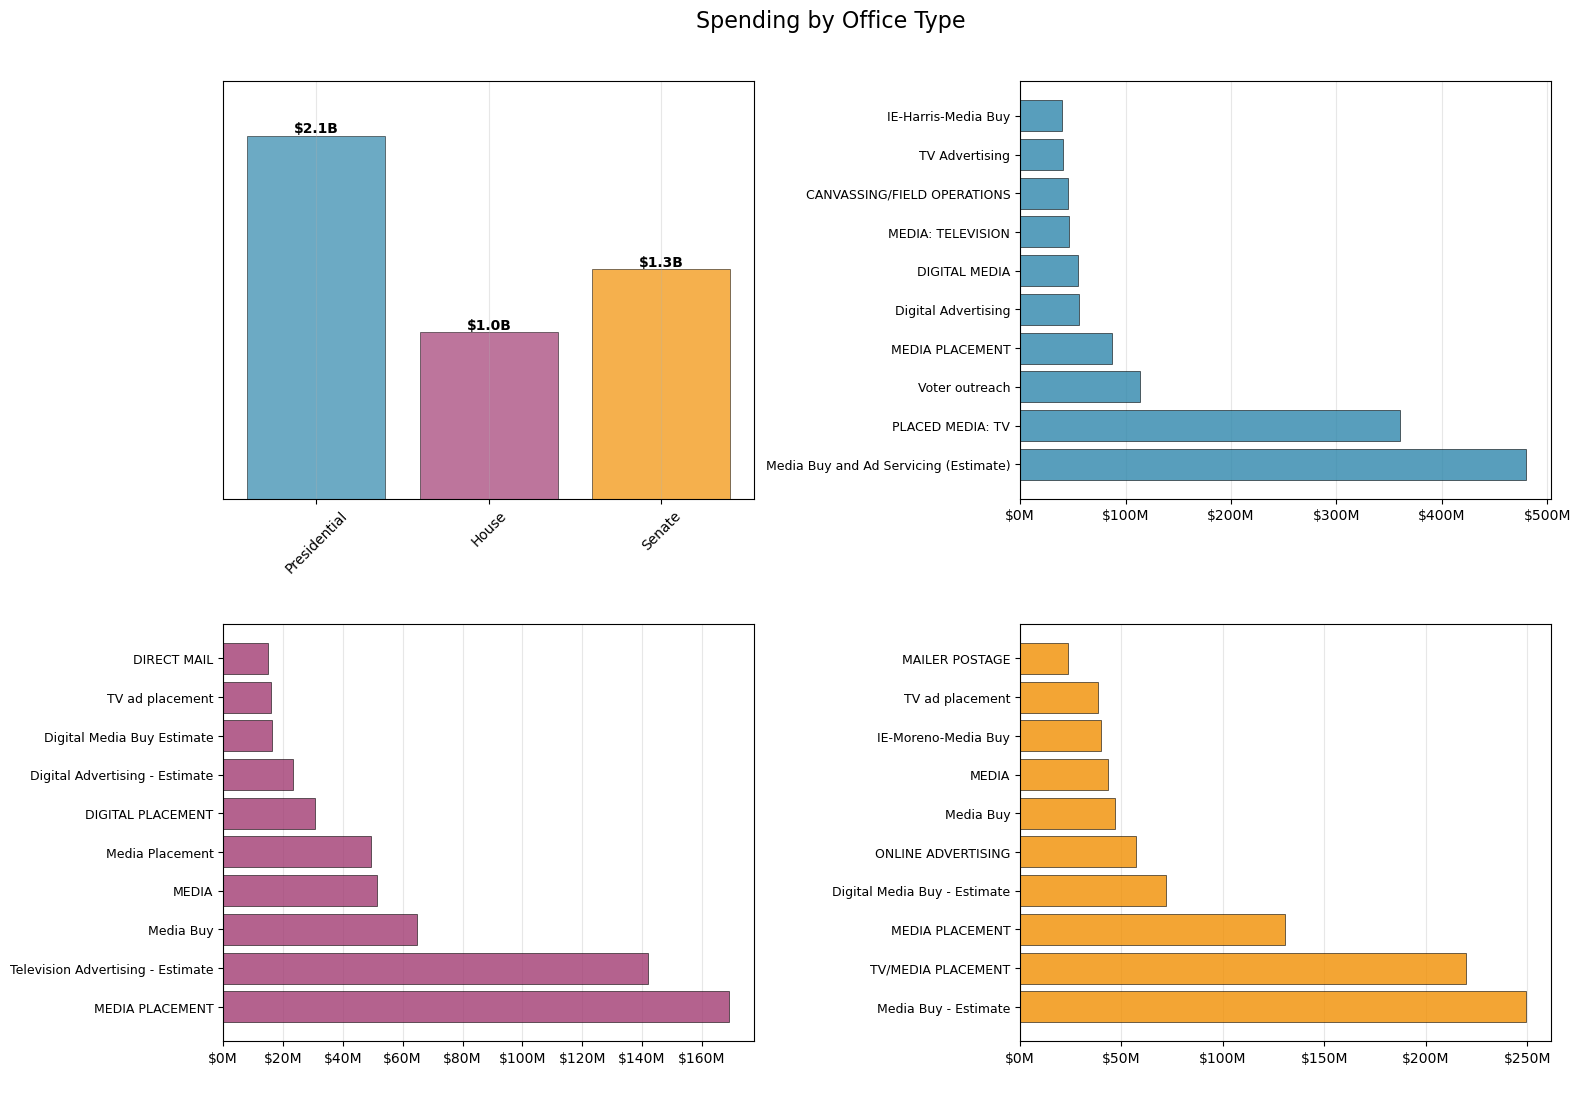

SUMMARY STATISTICS:
Presidential candidates total spending: $2,110,373,309.87
House candidates total spending: $968,203,829.64
Senate candidates total spending: $1,336,188,179.78
Total spending across all candidates: $4,415,014,497.82

Presidential spending as % of total: 47.8%
House spending as % of total: 21.9%
Senate spending as % of total: 30.3%


In [35]:
# Create combined 4-figure plot: Dollar amounts on top, House/Senate expenditures on bottom
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set the style
plt.style.use('default')

# Define consistent color scheme for each office type
office_colors = {
    'Presidential': '#2E86AB',  # Cool blue
    'House': '#A23B72',         # Cool purple/magenta
    'Senate': '#F18F01'         # Cool orange
}

# Create the 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Spending by Office Type', fontsize=16)
# Top Left: Dollar Amount Spent by Office Type
ax1 = axes[0, 0]
expenditures_dollars = df.groupby('can_office')['exp_amo'].sum()
# Reorder to match the desired order
expenditures_dollars_ordered = [expenditures_dollars['P'], expenditures_dollars['H'], expenditures_dollars['S']]
office_types_plot_1 = ['Presidential', 'House', 'Senate']

bars1 = ax1.bar(office_types_plot_1, expenditures_dollars_ordered,
                color=[office_colors['Presidential'], office_colors['House'], office_colors['Senate']],
                alpha=0.7, edgecolor='black', linewidth=0.5)
# ax1.set_title('Dollar Amount Spent\nby Office Type', fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)
# Remove y-axis, ticks, and labels for clean look
ax1.set_yticks([])
ax1.set_ylabel('')
# Fix y-axis bleeding by setting proper margins and limits
ax1.margins(y=0.15)
max_value = max(expenditures_dollars_ordered)
ax1.set_ylim(0, max_value * 1.15)

# Add value labels on top of bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'${height/1e9:.1f}B',
             ha='center', va='bottom', fontweight='bold')

# Top Right: Presidential candidates top expenditures
ax2 = axes[0, 1]
presidential_data = df[df['can_office'] == 'P']
presidential_expenditures = presidential_data.groupby('pur')['exp_amo'].sum().sort_values(ascending=False).head(10)

# Use variations of the presidential color
presidential_base_color = office_colors['Presidential']
presidential_colors = [presidential_base_color] * len(presidential_expenditures)
bars2 = ax2.barh(range(len(presidential_expenditures)), presidential_expenditures.values, 
                color=presidential_colors, alpha=0.8, edgecolor='black', linewidth=0.5)

# ax2.set_title('Top 10 Expenditures by Amount\n(Presidential Candidates)', fontweight='bold', fontsize=12)
# ax2.set_xlabel('Total Amount Spent ($)', fontsize=10, fontweight='bold')
ax2.set_yticks(range(len(presidential_expenditures)))
ax2.set_yticklabels(presidential_expenditures.index, fontsize=9)

# Format x-axis to show amounts in millions
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.0f}M'))
ax2.grid(axis='x', alpha=0.3)
ax2.set_axisbelow(True)

# Bottom Left: House candidates top expenditures
ax3 = axes[1, 0]
house_data = df[df['can_office'] == 'H']
house_expenditures = house_data.groupby('pur')['exp_amo'].sum().sort_values(ascending=False).head(10)

# Use variations of the house color
house_base_color = office_colors['House']
house_colors = [house_base_color] * len(house_expenditures)
bars3 = ax3.barh(range(len(house_expenditures)), house_expenditures.values, 
                color=house_colors, alpha=0.8, edgecolor='black', linewidth=0.5)

ax3.set_title('', fontweight='bold', fontsize=12)
# ax3.set_xlabel('\nTop 10 Expenditures by Amount\n(House Candidates)\n', fontsize=12)
ax3.set_yticks(range(len(house_expenditures)))
ax3.set_yticklabels(house_expenditures.index, fontsize=9)

# Format x-axis to show amounts in millions
ax3.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.0f}M'))
ax3.grid(axis='x', alpha=0.3)
ax3.set_axisbelow(True)

# Bottom Right: Senate candidates top expenditures
ax4 = axes[1, 1]
senate_data = df[df['can_office'] == 'S']
senate_expenditures = senate_data.groupby('pur')['exp_amo'].sum().sort_values(ascending=False).head(10)

# Use variations of the senate color
senate_base_color = office_colors['Senate']
senate_colors = [senate_base_color] * len(senate_expenditures)
bars4 = ax4.barh(range(len(senate_expenditures)), senate_expenditures.values, 
                color=senate_colors, alpha=0.8, edgecolor='black', linewidth=0.5)

ax4.set_title('', fontweight='bold', fontsize=12)
ax4.set_xlabel(' \n ', fontsize=12)
ax4.set_yticks(range(len(senate_expenditures)))
ax4.set_yticklabels(senate_expenditures.index, fontsize=9)

# Format x-axis to show amounts in millions
ax4.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.0f}M'))
ax4.grid(axis='x', alpha=0.3)
ax4.set_axisbelow(True)

# Adjust layout for balanced white space - increase spacing between subplots
plt.tight_layout()
plt.subplots_adjust(top=0.92, bottom=0.12, left=0.12, right=0.95, hspace=0.3, wspace=0.5)
plt.savefig('images/election_expenditure_analysis_iteration_3.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

# Print summary statistics
print("SUMMARY STATISTICS:")
print("=" * 60)
print(f"Presidential candidates total spending: ${presidential_data['exp_amo'].sum():,.2f}")
print(f"House candidates total spending: ${house_data['exp_amo'].sum():,.2f}")
print(f"Senate candidates total spending: ${senate_data['exp_amo'].sum():,.2f}")
print(f"Total spending across all candidates: ${df['exp_amo'].sum():,.2f}")
print(f"\nPresidential spending as % of total: {(presidential_data['exp_amo'].sum() / df['exp_amo'].sum()) * 100:.1f}%")
print(f"House spending as % of total: {(house_data['exp_amo'].sum() / df['exp_amo'].sum()) * 100:.1f}%")
print(f"Senate spending as % of total: {(senate_data['exp_amo'].sum() / df['exp_amo'].sum()) * 100:.1f}%")
